In [1]:
from torchvision.datasets import MNIST
from torchvision import transforms
import torch
from torch.utils.data import DataLoader, Dataset

from model import *

import pandas as pd

import matplotlib.pyplot as plt
import torch.nn as nn
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [2]:
from model import create_lightweight_detector

yolo = create_lightweight_detector()

In [3]:
df = pd.read_parquet("trailer-53ft-data/data.parquet")

print(df.head())

           name               image_path               scene_path  \
0  ywS7Z8PYDwzU  images/ywS7Z8PYDwzU.png  scenes/ywS7Z8PYDwzU.xml   
1  qVq9KrxI6cUJ  images/qVq9KrxI6cUJ.png  scenes/qVq9KrxI6cUJ.xml   
2  t4etaisoU0XU  images/t4etaisoU0XU.png  scenes/t4etaisoU0XU.xml   
3  EavwTEpzWeZF  images/EavwTEpzWeZF.png  scenes/EavwTEpzWeZF.xml   
4  N1bhJZadcJRJ  images/N1bhJZadcJRJ.png  scenes/N1bhJZadcJRJ.xml   

   volume_occupancy  floor_occupancy          scenario  
0          0.265683         0.399375  mixed-cargo-type  
1          0.001135         0.008125  mixed-cargo-type  
2          0.015896         0.028125  mixed-cargo-type  
3          0.511350         0.629687  mixed-cargo-type  
4          0.240704         0.325000  mixed-cargo-type  


In [4]:
df["volume_occupancy"].describe()

count    430.000000
mean       0.222942
std        0.198857
min        0.000000
25%        0.009130
50%        0.199830
75%        0.344656
max        0.703946
Name: volume_occupancy, dtype: float64

In [5]:
import matplotlib.pyplot as plt
import torch

def show_rgb_tensor(tensor):
    img = tensor.detach().cpu().numpy()
    
    if img.ndim == 4:
        img = img[0]
    
    if img.shape[0] == 3: 
        img = img.transpose(1, 2, 0)
    
    img = (img - img.min()) / (img.max() - img.min())
    
    plt.imshow(img)
    plt.axis('off')
    plt.show()

In [6]:
from PIL import Image
import os
import numpy as np

class TrailerDataModule(Dataset):
    def __init__(self, annotations_file, image_dir, transform=None, target_transform=None):
        self.annotations = pd.read_parquet(annotations_file)
        self.image_dir = image_dir
        self.transform = transform
        self.target_transform = target_transform

    def __len__(self):
        return len(self.annotations)
    
    def __getitem__(self, idx):
        img_path = os.path.join(self.image_dir, self.annotations.iloc[idx, 1])
        image = Image.open(img_path).convert("RGB")
        # label = self.annotations.iloc[idx, 3]

        label = np.digitize(self.annotations.iloc[idx, 3], bins= [0, 0.1, 0.5])
        

        if self.transform:
            image = self.transform(image)
        if self.target_transform:
            label = self.target_transform(label)

        return image, label

In [7]:
labels = np.digitize(df["volume_occupancy"], bins = [0, 0.1, 0.5])

In [8]:
np.unique(labels, return_counts=True)

(array([1, 2, 3]), array([153, 222,  55]))

In [9]:
from torchvision.transforms import v2
transform = v2.Compose(
    [
        v2.ToTensor(),
        v2.Resize([224, 224]),
        v2.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
        
    ]
)
data = TrailerDataModule(annotations_file="trailer-53ft-data/data.parquet", image_dir="trailer-53ft-data", transform=transform)

/Users/rissalhedna/Desktop/UNet-from-scratch/.venv/lib/python3.10/site-packages/torchvision/transforms/v2/_deprecated.py:42: UserWarning: The transform `ToTensor()` is deprecated and will be removed in a future release. Instead, please use `v2.Compose([v2.ToImage(), v2.ToDtype(torch.float32, scale=True)])`.Output is equivalent up to float precision.
  warnings.warn(


2


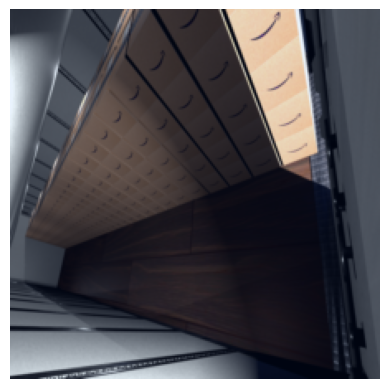

In [10]:

idx = torch.randint(0, len(data), (1,)).item()

print(data[idx][1])
show_rgb_tensor(data[idx][0])


In [11]:
from sklearn.model_selection import train_test_split 

train, test = train_test_split(data, test_size=0.2, random_state=42, shuffle=True)

In [12]:
train_dataloader = DataLoader(train, batch_size=100, shuffle=True)
test_dataloader = DataLoader(test, batch_size=100, shuffle=True)

for X, y in train_dataloader:
    print(X.shape)
    print(y.shape)
    break

torch.Size([100, 3, 224, 224])
torch.Size([100])


In [13]:
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(yolo.parameters(), lr=1e-3)

In [16]:
for batch, (X,y) in enumerate(train_dataloader):
    print(X.shape)
    print(y.shape)
    break

torch.Size([100, 3, 224, 224])
torch.Size([100])


In [17]:
def train(dataloader, model, loss_fn, optimizer):
    size = len(dataloader.dataset)
    model.train()
    for batch, (X,y) in enumerate(dataloader):
        X, y = X.to(device), y.to(device)

        pred = model(X)
        loss = loss_fn(pred, y)

        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

        if batch % 100 == 0:
            loss, current = loss.item(), (batch + 1) * len(X)
            print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")

In [18]:
for epoch in range(1):
    train(train_dataloader, yolo, loss_fn, optimizer)

AttributeError: 'list' object has no attribute 'shape'

In [9]:
def test(dataloader, model, loss_fn):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)

    model.eval()
    test_loss, correct = 0,0

    with torch.no_grad():
        for X, y in dataloader:
            X, y = X.to(device), y.to(device)
            pred = model(X)
            test_loss += loss_fn(pred, y).item()
            correct += (pred.argmax(1) == y).type(torch.float).sum().item()
        test_loss /= num_batches
        correct/=size
        print(f"Test Error: \n Accuracy: {(100*correct):>0.1f}%, Avg loss: {test_loss:>8f} \n")

In [10]:
test(test_data_loader, model, loss_fn)

Test Error: 
 Accuracy: 98.4%, Avg loss: 0.051056 



In [68]:
def save(model, file='./model'):
    torch.save(model.state_dict(),file)

In [69]:
save(model)

In [13]:
sample_idx = torch.randint(len(train_data), size= (1,)).item()

pred = model(train_data[sample_idx][0].view(1,1,28,28)).argmax(1).item()
truth = train_data[sample_idx][1]

print(f"Prediction: {pred}. Ground truth: {truth}")

Prediction: 5. Ground truth: 5


In [16]:
t = torch.ones(size=(3,2,))

In [17]:
t

tensor([[1., 1.],
        [1., 1.],
        [1., 1.]])

In [18]:
n = t.numpy()

In [19]:
n

array([[1., 1.],
       [1., 1.],
       [1., 1.]], dtype=float32)

In [32]:
t.add_(2)

tensor([[12., 12.],
        [12., 12.],
        [12., 12.]])

In [33]:
n

array([[12., 12.],
       [12., 12.],
       [12., 12.]], dtype=float32)